In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches # for bounding box

import torch
import torch.nn as nn
import torchvision.models.detection

from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as ET 
from PIL import Image
from tqdm import tqdm

import math
import time
import random

from pathlib import Path

C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# DATA_PATH = Path("data/")
CHECKPOINT_PATH = "checkpoints/"
# RESULTS_PATH = Path("results/")

def save_random_indices(rand_indices):
    with open(CHECKPOINT_PATH + "indices.npy", 'wb') as f:
        np.save(f, rand_indices)

def get_random_indices(is_get_new=False):
    if is_get_new:
        rand_indices = np.random.permutation(np.arange(total_len))
        return rand_indices
            
    try:
        rand_indices = np.load(CHECKPOINT_PATH + "indices.npy")
        print("[V] Load saved random indices")
        return rand_indices
    except:
        print("[E] Unable to load saved random indices")
        return None
    
def save_model_checkpoint(model, epoch, loss, prefix=""):
    cp_name = f"model_{prefix}_{epoch:02d}.pt"
    full_file_name = CHECKPOINT_PATH + cp_name
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, full_file_name)

In [4]:
inputs = np.load("./Datasets/processed_all_input_reduced.npy")
df = pd.read_csv("./Datasets/processed_all_output_reduced.csv")  # output
inputs.shape, df.shape

((3479, 3, 176, 240), (3479, 9))

In [5]:
num_classes = df['label'].unique().shape[0]

In [6]:
def show_gpu_usage():
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

# Prepare Data

In [7]:
# shuffle and prepare for train test split
TRAIN_RATIO = 0.8
total_len = inputs.shape[0]
train_len = math.floor(total_len * TRAIN_RATIO)

rand_indices = get_random_indices()
train_indices, test_indices = rand_indices[:train_len], rand_indices[train_len:]

#  = torch.Tensor(inputs[:train_len])

[V] Load saved random indices


In [8]:
# x data
x_train, x_test = torch.Tensor(inputs[train_indices]), torch.Tensor(inputs[test_indices])
del inputs

print(f"X-TRAIN={x_train.shape}\tX-TEST={x_test.shape}")

X-TRAIN=torch.Size([2783, 3, 176, 240])	X-TEST=torch.Size([696, 3, 176, 240])


In [9]:
# save_random_indices(rand_indices)

In [10]:
# labels
labels = np.array(df['label'])
labels = np.expand_dims(labels, 1)
labels_train, labels_test = torch.LongTensor(labels[train_indices]), torch.LongTensor(labels[test_indices])

# boxes
boxes_np = np.array(df[['x1', 'y1', 'x2', 'y2']])
boxes_np = np.expand_dims(boxes_np, 1)
boxes_np = boxes_np# TODO:??? / 256
# boxes_all = torch.Tensor(boxes_np)
boxes_train, boxes_test = torch.Tensor(boxes_np[train_indices]), torch.Tensor(boxes_np[test_indices])

print(f"LABEL: TRAIN={labels_train.shape}\tTEST={labels_test.shape}")
print(f"BOXES: TRAIN={boxes_train.shape}\tTEST={boxes_test.shape}")

LABEL: TRAIN=torch.Size([2783, 1])	TEST=torch.Size([696, 1])
BOXES: TRAIN=torch.Size([2783, 1, 4])	TEST=torch.Size([696, 1, 4])


In [11]:
# Concate labels and boxes
targets_train = []
for i in range(train_len):
    d = {}
    d['boxes'] = boxes_train[i].to(device)
    d['labels'] = labels_train[i].to(device)
    targets_train.append(d)

In [12]:
show_gpu_usage()

torch.cuda.memory_allocated: 0.002654GB
torch.cuda.memory_reserved: 0.003906GB
torch.cuda.max_memory_reserved: 0.003906GB


# Use Helper Functions from PyTorch repo

In [13]:
# !git clone https://github.com/pytorch/vision.git
# %cd vision
# !git checkout v0.3.0

# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../

# Develop Model

In [14]:
def init_func():
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#             weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    
    return model, criterion, optimizer

In [15]:
model, criterion, optimizer = init_func()

C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def dfs_freeze(model):
    for name, child in model.named_children():
        if name == 'box_predictor':
            print("[V] Last layer, need grad")
            print(child)
            continue
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


In [17]:
# dfs_freeze(model)

In [18]:
predictions = model(x_train[1:2].to(device), targets_train[1:2])

In [19]:
predictions

{'loss_classifier': tensor(2.8461, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1285, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0147, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)}

In [20]:
NUM_EPOCHES = 5
bs = 2

In [21]:
# mean, std = x_train.mean(), x_train.std()
# mean = mean.to(device)
# std = std.to(device)

In [22]:
show_gpu_usage()

torch.cuda.memory_allocated: 0.807168GB
torch.cuda.memory_reserved: 0.978516GB
torch.cuda.max_memory_reserved: 0.978516GB


In [23]:
start = time.time()

for epoch in range(NUM_EPOCHES):
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(train_len)
 
    for count in tqdm(range(0, train_len, bs)):
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data    = x_train[indices].to(device)
        minibatch_targets = [targets_train[idx] for idx in indices]
#         minibatch_data = x_train[count:count+bs]
#         minibatch_targets = targets_train[count:count+bs]
        
        # send them to the gpu
#         minibatch_data    = minibatch_data.to(device)
#         minibatch_targets = minibatch_targets.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = minibatch_data # (minibatch_data - mean) / std 
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net and get loss
        loss_dict = model(inputs, minibatch_targets) 
        losses = sum(loss for loss in loss_dict.values())
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        losses.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += losses.detach().item()
        
        # compute the error made on this batch and add it to the running error       
#         error = utils.get_error( scores.detach() , minibatch_label)
#         running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
#     total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed, 'min', '\t loss=', total_loss)
    
    save_model_checkpoint(model, epoch, total_loss, prefix="full")
    

#     print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
#     eval_on_test_set() 
#     print(' ')

100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [08:23<00:00,  2.77it/s]


epoch= 0 	 time= 8.387813079357148 min 	 loss= 0.1976511914018092


100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [08:23<00:00,  2.76it/s]


epoch= 1 	 time= 16.7898229320844 min 	 loss= 0.1699347690366016


100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [08:23<00:00,  2.76it/s]


epoch= 2 	 time= 25.189536686738332 min 	 loss= 0.16087355621656851


100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [08:25<00:00,  2.76it/s]


epoch= 3 	 time= 33.61710495948792 min 	 loss= 0.1548978062239529


100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [08:24<00:00,  2.76it/s]


epoch= 4 	 time= 42.02694834470749 min 	 loss= 0.14305530229433513


# Evaluation

In [30]:
def load_checkpoint(ep_id):
    model, criterion, optimizer = init_func()
    
    cp_name = f"model_full_{ep_id:02d}.pt"
    full_file_name = CHECKPOINT_PATH + cp_name
    checkpoint = torch.load(full_file_name)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model

EPOCH_ID = 4
model = load_checkpoint(EPOCH_ID)

In [31]:
res = model.eval()

In [32]:
def test_and_vis_one_img(x_torch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # predict
    if x_torch.dim() == 3:
        x_torch_4d = torch.unsqueeze(x_torch, 0)
    predictions = model(x_torch_4d.to(device))
    pred = predictions[0]
    box = pred['boxes'][0].cpu().detach()
    label = pred['labels'][0].item()
    score = pred['scores'][0].item()
    
    # get data for display
    img = np.moveaxis(x_torch.numpy(), [0, 1, 2], [2, 0, 1]) * 256
    img = Image.fromarray(img.astype(np.uint8))
    x1, y1, x2, y2 = box
    
    # plot
    print(f"Label={label}\tConfidence={score}")
    fig, ax = plt.subplots()
    ax.imshow(img)
    if score >= 0.1:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Label=15	Confidence=0.6428277492523193


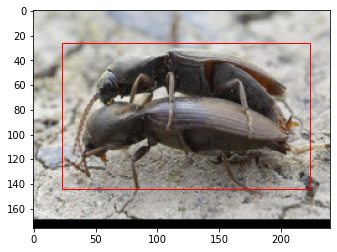

In [38]:
xx = x_test
p = test_and_vis_one_img(xx[random.randint(0, len(xx))])

In [28]:
torch.unsqueeze(x_test[0], 0).dim()

4

In [29]:
pred = predictions[0]
box = pred['boxes'][0]
label = pred['labels'][0].item()

pred.keys()

KeyError: 0

In [ ]:
def visualise_img(img_np, box):
    img = img_np * 256
    img = Image.fromarray(img.astype(np.uint8))
    x1, y1, x2, y2 = box

    # plot img and bbox
    

In [ ]:
# img1, box1 = show_img(x_test[0].to(device), box, label)
# visualise_img(img1, box1)